<a href="https://colab.research.google.com/github/jamestheengineer/data-science-from-scratch-Python/blob/master/Chapter_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Scraping the web. We'll use a couple external packages (i.e., not from scratch)
#!pip install beautifulsoup4 requests html5lib

# Only do this once per VM, otherwise you'll get multiple clones and nested directories
!git clone https://github.com/jamestheengineer/data-science-from-scratch-Python.git
%cd data-science-from-scratch-Python/
!pip install import-ipynb
!pip install pillow
import import_ipynb

# NLP

data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]


Cloning into 'data-science-from-scratch-Python'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 561 (delta 110), reused 3 (delta 1), pack-reused 387
Receiving objects: 100% (561/561), 1.55 MiB | 1004.00 KiB/s, done.
Resolving deltas: 100% (350/350), done.
/content/data-science-from-scratch-Python
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=8d8a345804318d17656f32aed6201cbadabdf870585cd83f882761da7fa328a0
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


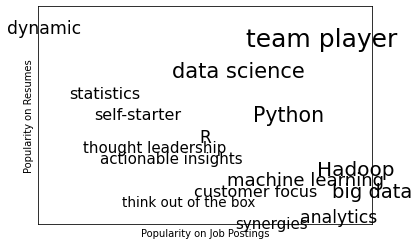

In [2]:
from matplotlib import pyplot as plt

def text_size(total: int) -> float:
  """equals 8 if total is 0, 28 if total is 200"""
  return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
  plt.text(job_popularity, resume_popularity, word, 
           ha='center', va='center',
           size=text_size(job_popularity + resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0,100,0,100])
plt.xticks([])
plt.yticks([])
plt.show()

In [3]:
# Make a bunch of webpages example
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "main-post-radar-content")   # find right content div
regex = r"[\w']+|[\.]"                       # matches a word or a period
document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

print(document)

['Weâ', 've', 'all', 'heard', 'it', 'according', 'to', 'Hal', 'Varian', 'statistics', 'is', 'the', 'next', 'sexy', 'job', '.', 'Five', 'years', 'ago', 'in', 'What', 'is', 'Web', '2', '.', '0', 'Tim', 'Oâ', 'Reilly', 'said', 'that', 'â', 'data', 'is', 'the', 'next', 'Intel', 'Inside', '.', 'â', 'But', 'what', 'does', 'that', 'statement', 'mean', 'Why', 'do', 'we', 'suddenly', 'care', 'about', 'statistics', 'and', 'about', 'data', 'In', 'this', 'post', 'I', 'examine', 'the', 'many', 'sides', 'of', 'data', 'science', 'â', 'the', 'technologies', 'the', 'companies', 'and', 'the', 'unique', 'skill', 'sets', '.', 'Join', 'the', "O'Reilly", 'online', 'learning', 'platform', '.', 'Get', 'a', 'free', 'trial', 'today', 'and', 'find', 'answers', 'on', 'the', 'fly', 'or', 'master', 'something', 'new', 'and', 'useful', '.', 'The', 'web', 'is', 'full', 'of', 'â', 'data', 'driven', 'apps', '.', 'â', 'Almost', 'any', 'e', 'commerce', 'application', 'is', 'a', 'data', 'driven', 'application', '.', 'Ther

In [4]:
from collections import defaultdict
import random

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
  transitions[prev].append(current)

def generate_using_bigrams() -> str:
  current = "." # this means the next word will start a sentence
  result = []
  while True:
    next_word_candidates = transitions[current] # bigrams (current, _)
    current = random.choice(next_word_candidates) # choose one at random
    result.append(current) # append it to results
    if current == ".": return " ".join(result) # if "." we're done

# You can make sentences less gibberishly by using trigrams instead of bigrams
trigram_transitions = defaultdict(list)
starts = []
for prev, current, next in zip(document, document[1:], document[2:]):
  if prev == ".":  # if the previous word was a period
    starts.append(current) # then this is a start word
  
  trigram_transitions[(prev, current)].append(next)

def generate_using_trigrams() -> str:
  current = random.choice(starts)
  prev = "."
  result = [current]
  while True:
    next_word_candidates = trigram_transitions[(prev, current)]
    next_word = random.choice(next_word_candidates)

    prev, current = current, next_word
    result.append(current)

    if current == ".":
      return " ".join(result)

In [5]:
# Grammars
from typing import List, Dict

# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

def is_terminal(token: str) -> bool:
  return token[0] != "_"

def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
  for i, token in enumerate(tokens):
    # if this is a terminal token, skip it
    if is_terminal(token): continue

    # Otherwise, it's a nonterminal token, 
    # so we need to choose a replacement at random.
    replacement = random.choice(grammar[token])

    if is_terminal(replacement):
      tokens[i] = replacement
    else:
      # Replacement be another nonterminal
      tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
    
    # now call expand on the new list of tokens
    return expand(grammar, tokens)
  # If we get here, we had all terminals and are done
  return tokens

def generate_sentence(grammar: Grammar) -> List[str]:
  return expand(grammar, ["_S"])

In [6]:
print(generate_sentence(grammar))

['linear', 'regression', 'about', 'big', 'regression', 'trains', 'Python']


In [7]:
# Gibbs sampling - a way to sample hard to sample distributions

# Rolling a dice example
from typing import Tuple
import random

def roll_a_die() -> int:
  return random.choice([1,2,3,4,5,6])

def direct_sample() -> Tuple[int, int]:
  d1 = roll_a_die()
  d2 = roll_a_die()
  return d1, d1 + d2

def random_y_given_x(x: int) -> int:
  """equally likely to be x+1, x+2, ..., x+6"""
  return x + roll_a_die()

def random_x_given_y(y: int) -> int:
  if y <= 7:
    # if the total is 7 or less, the first die is equally likely to be
    # 1, 2, ...., (total - 1)
    return random.randrange(1, y)
  else:
    # if the total is 7 or more, the first die is equally likely to be
    # (total - 6), (total - 5), ..., 6
    return random.randrange(y - 6, 7)

def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
  x, y = 1, 2 # doesn't really matter
  for _ in range(num_iters):
    x = random_x_given_y(y)
    y = random_y_given_x(x)
  return x, y

def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
  counts = defaultdict(lambda: [0,0])
  for _ in range(num_samples):
    counts[gibbs_sample()][0] += 1
    counts[direct_sample()][1] += 1
  return counts

In [8]:
def sample_from(weights: List[float]) -> int:
  """returns i with probability weights[i] / sum(weights)"""
  total = sum(weights)
  rnd = total * random.random() # uniform between 0 and total
  for i, w in enumerate(weights):
    rnd -= w      # return the smallest i such that
    if rnd <= 0: return i # weights[0] + ... + weights[i] >= rnd

from collections import Counter

# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190 # should be ~10%, this is really a loose test
assert 10 < draws[1] < 190 # should be ~10%, this is really a loose test
assert 650 < draws[2] < 950 # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

In [9]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [10]:
K = 4

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

# number of distinct words
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

# number of documents
D = len(documents)

print(D)


15


In [11]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
  """
  The fraction of words in document 'd'
  that are assigned to 'topic' (plus some smoothing)
  """
  return ((document_topic_counts[d][topic] + alpha) / 
          (document_lengths[d] + K * alpha))

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
  """
  The fraction of words assigned to 'topic'
  that equal 'word' (plus some smoothing)
  """
  return ((topic_word_counts[topic][word] + beta) /
          (topic_counts[topic] + W * beta))
  
def topic_weight(d: int, word: str, k: int) -> float:
  """
  Given a document and a word in that document,
  return the weight for the kth topic
  """
  return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str) -> int:
  return sample_from([topic_weight(d, word, k)
                      for k in range(K)])
  
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
  for word, topic in zip(documents[d], document_topics[d]):
    document_topic_counts[d][topic] += 1
    topic_word_counts[topic][word] += 1
    topic_counts[topic] += 1


In [12]:
import tqdm

for iter in tqdm.trange(1000):
  for d in range(D):
    for i, (word, topic) in enumerate(zip(documents[d],
                                          document_topics[d])):
      # remove this word / topic from the counts
      # so that it doesn't influence the weights
      document_topic_counts[d][topic] -= 1
      topic_word_counts[topic][word] -= 1
      topic_counts[topic] -= 1
      document_lengths[d] -= 1

      # choose a new topic based on the weights
      new_topic = choose_new_topic(d, word)
      document_topics[d][i] = new_topic

      # and now add it back to the counts
      document_topic_counts[d][new_topic] += 1
      topic_word_counts[new_topic][word] += 1
      topic_counts[new_topic] += 1
      document_lengths[d] += 1

for k, word_counts in enumerate(topic_word_counts):
  for word, count in word_counts.most_common():
    if count > 0:
      print(k, word, count)

100%|██████████| 1000/1000 [00:00<00:00, 1799.69it/s]

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1


In [13]:
# The above results are stochastic, so the below topics might not be true
topic_names = ["Big data and programming languages",
               "Python and statistics",
               "databases",
               "artificial intelligence"]

for document, topic_counts in zip(documents, document_topic_counts):
  print(document)
  for topic, count in topic_counts.most_common():
    if count > 0:
      print(topic_names[topic], count)
  print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Python and statistics 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statistics 2
databases 2
artificial intelligence 2

['R', 'Python', 'statistics', 'regression', 'probability']
artificial intelligence 3
databases 2

['machine learning', 'regression', 'decision trees', 'libsvm']
databases 2
Python and statistics 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
databases 3
Big data and programming languages 3

['statistics', 'probability', 'mathematics', 'theory']
artificial intelligence 3
databases 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
databases 2
Python and statistics 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Python and statistics 3
Big data and programming languages 1

['Hadoop', 'Java', 'MapReduc

In [14]:
# Deep learning is the new hotness
from Chapter_04 import dot, Vector
import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
  return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

assert cosine_similarity([1., 1, 1],[2.,2,2]) == 1 # same direction
assert cosine_similarity([-1.,-1],[2.,2]) == -1 # opposite direction
assert cosine_similarity([1.,0],[0.,1]) == 0 # orthogonal

importing Jupyter notebook from Chapter_04.ipynb


In [15]:
colors = ["red", "green", "blue","yellow","black",""]
nouns = ["bed","car","boat","cat"]
verbs = ["is", "was","seems"]
adverbs=["very","quite","extremely",""]
adjectives=["slow","fast","soft","hard"]

def make_sentence() -> str:
  return " ".join([
      "The",
      random.choice(colors),
      random.choice(nouns),
      random.choice(verbs),
      random.choice(adverbs),
      random.choice(adjectives),
      "."
  ])

NUM_SENTENCES = 50
random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]
print(sentences)

['The yellow cat is extremely hard .', 'The yellow boat was extremely fast .', 'The black car was quite slow .', 'The black boat seems quite soft .', 'The red bed seems extremely hard .', 'The black bed was  soft .', 'The black car seems  hard .', 'The black boat is very slow .', 'The  cat seems very hard .', 'The blue car seems extremely slow .', 'The green car is quite hard .', 'The red bed was  slow .', 'The blue boat seems very soft .', 'The black car seems extremely hard .', 'The red cat was quite soft .', 'The green car is very soft .', 'The yellow bed is quite fast .', 'The red bed seems  soft .', 'The black car is  soft .', 'The yellow cat seems extremely slow .', 'The blue bed was extremely fast .', 'The green bed seems extremely slow .', 'The  car was quite soft .', 'The yellow bed is quite fast .', 'The red bed is very fast .', 'The black bed was very soft .', 'The red bed seems very fast .', 'The green bed was quite slow .', 'The  bed seems  slow .', 'The blue bed is very s

importing Jupyter notebook from Chapter_19.ipynb
importing Jupyter notebook from Chapter_18.ipynb
1 1 1
1 / 100
2 2 2
2 / 100
3 3 fizz
2 / 100
4 fizzbuzz 4
2 / 100
5 5 buzz
2 / 100
6 fizzbuzz fizz
2 / 100
7 7 7
3 / 100
8 buzz 8
3 / 100
9 buzz fizz
3 / 100
10 10 buzz
3 / 100
11 buzz 11
3 / 100
12 fizzbuzz fizz
3 / 100
13 13 13
4 / 100
14 14 14
5 / 100
15 15 fizzbuzz
5 / 100
16 16 16
6 / 100
17 17 17
7 / 100
18 18 fizz
7 / 100
19 19 19
8 / 100
20 20 buzz
8 / 100
21 21 fizz
8 / 100
22 22 22
9 / 100
23 23 23
10 / 100
24 24 fizz
10 / 100
25 25 buzz
10 / 100
26 26 26
11 / 100
27 27 fizz
11 / 100
28 28 28
12 / 100
29 29 29
13 / 100
30 30 fizzbuzz
13 / 100
31 31 31
14 / 100
32 32 32
15 / 100
33 33 fizz
15 / 100
34 34 34
16 / 100
35 35 buzz
16 / 100
36 36 fizz
16 / 100
37 37 37
17 / 100
38 38 38
18 / 100
39 39 fizz
18 / 100
40 40 buzz
18 / 100
41 41 41
19 / 100
42 42 fizz
19 / 100
43 43 43
20 / 100
44 44 44
21 / 100
45 45 fizzbuzz
21 / 100
46 46 46
22 / 100
47 47 47
23 / 100
48 48 fizz
23 / 100

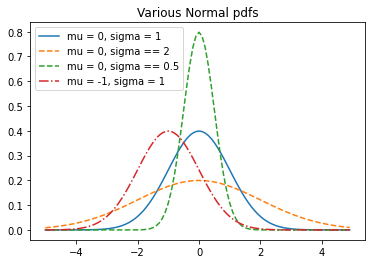

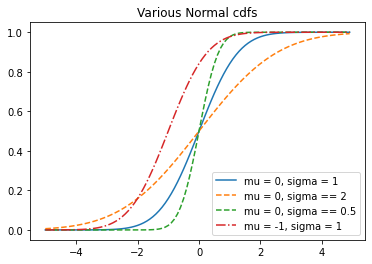

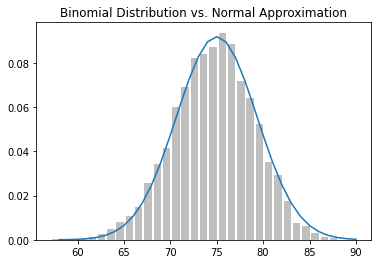

/content/data-science-from-scratch-Python


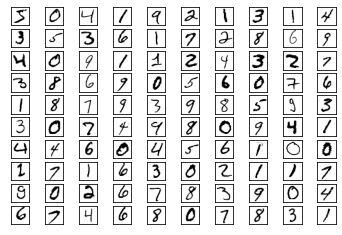

In [16]:
# Let's make a vocabulary class to start some real work
from Chapter_19 import Tensor

In [17]:
class Vocabulary:
  def __init__(self, words: List[str] = None) -> None:
    self.w2i: Dict[str, int] = {} # mapping word -> word_id
    self.i2w: Dict[int, str] = {} # mapping word_id -> word

    for word in (words or []):  # if words were provided
      self.add(word)            # add them

  @property
  def size(self) -> int:
    """how many words are in the vocabulary"""
    return len(self.w2i)
  
  def add(self, word: str) -> None:
    if word not in self.w2i:
      word_id = len(self.w2i)
      self.w2i[word] = word_id
      self.i2w[word_id] = word
    
  def get_id(self, word: str) -> int:
    """return the id of the word or None"""
    return self.w2i.get(word)

  def get_word(self, word_id: int) -> str:
    """return the word with the given id or None"""
    return self.i2w.get(word_id)

  def one_hot_encode(self, word: str) -> Tensor:
    word_id = self.get_id(word)
    assert word_id is not None, f"unknown word {word}"

    return [1.0 if i == word_id else 0.0 for i in range(self.size)]

In [18]:
vocab = Vocabulary(["a","b","c"])
assert vocab.size == 3
assert vocab.get_id("b") == 1
assert vocab.one_hot_encode("b") == [0,1,0]
assert vocab.get_id("z") is None
assert vocab.get_word(2) == "c"
vocab.add("z")
assert vocab.size == 4
assert vocab.get_id("z") == 3
assert vocab.one_hot_encode("z") == [0, 0, 0, 1]

In [19]:
import json

def save_vocab(vocab: Vocabulary, filename: str) -> None:
  with open(filename, 'w') as f:
    json.dump(vocab.w2i, f) # Only need to save w2i

def load_vocab(filename: str) -> Vocabulary:
  vocab = Vocabulary()
  with open(filename) as f:
    # Load w2i and generate i2w from it
    vocab.w2i = json.load(f)
    vocab.i2w = {id: word for word, id in vocab.w2i.items()}
  return vocab

In [20]:
from typing import Iterable
from Chapter_19 import Layer, Tensor, random_tensor, zeros_like

class Embedding(Layer):
  def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
    self.num_embeddings = num_embeddings
    self.embedding_dim = embedding_dim

    # One vector of size embedding_dim for each desired embedding
    self.embeddings = random_tensor(num_embeddings, embedding_dim)
    self.grad = zeros_like(self.embeddings)

    # Save last input id
    self.last_input_id = None

  def forward(self, input_id: int) -> Tensor:
    """Just select the embedding vector corresponding to the input id"""
    self.input_id = input_id # remember for use in backpropagation

    return self.embeddings[input_id]

  def backward(self, gradient: Tensor) -> None:
    # Zero out the gradient corresponding to the last input
    # This is way cheaper than creating a new all-zero tensor each time
    if self.last_input_id is not None:
      zero_row = [0 for _ in range(self.embedding_dim)]
      self.grad[self.last_input_id] = zero_row
    
    self.last_input_id = self.input_id
    self.grad[self.input_id] = gradient

  def params(self) -> Iterable[Tensor]:
    return [self.embeddings]

  def grads(self) -> Iterable[Tensor]:
    return [self.grad]

In [21]:
class TextEmbedding(Embedding):
  def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
    # Call the superclass constructor
    super().__init__(vocab.size, embedding_dim)

    # And hang onto the vocab
    self.vocab = vocab

  def __getitem__(self, word: str) -> Tensor:
    word_id = self.vocab.get_id(word)
    if word_id is not None:
      return self.embeddings[word_id]
    else:
      return None

  def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
    """Returns the n closest words based on cosine similarity"""
    vector = self[word]

    # Compute pairs (similarity, other_word), and sort most similar first
    scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
              for other_word, i in self.vocab.w2i.items()]
    scores.sort(reverse=True)

    return scores[:n]



In [22]:
import re

# This is not a great regex, but it works on our data
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                        for sentence in sentences]

# Create a vocabulary (that is, a mapping word -> word_id) based on our text.
vocab = Vocabulary(word
                   for sentence_words in tokenized_sentences
                   for word in sentence_words)

from Chapter_19 import Tensor

inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tokenized_sentences:
  for i, word in enumerate(sentence):
    for j in [i - 2, i - 1, i + 1, i + 2]:
      if 0 <= j < len(sentence):
        nearby_word = sentence[j]

        # Add an input that's the original word_id
        inputs.append(vocab.get_id(word))

        # Add a target that's the one-hot-encoded nearby word
        targets.append(vocab.one_hot_encode(nearby_word))

from Chapter_19 import Sequential, Linear

random.seed(0)
EMBEDDING_DIM = 5

# Define the embedding layer separately, so we can reference it
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)

model = Sequential([
                    # Given a word as a vector of word_ids, look up its embedding
                    embedding,
                    # And use a linear layer to compute scores for nearby words
                    Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size)
])

In [24]:
# Let's get ready to train
from Chapter_19 import SoftmaxCrossEntropy, Momentum, GradientDescent

loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate = 0.01)

for epoch in range(100):
  epoch_loss = 0.0
  for input, target in zip(inputs, targets):
    predicted = model.forward(input)
    epoch_loss += loss.loss(predicted, target)
    gradient = loss.gradient(predicted, target)
    model.backward(gradient)
    optimizer.step(model)
  print(epoch, epoch_loss)
  print(embedding.closest("black"))
  print(embedding.closest("slow"))
  print(embedding.closest("car"))

0 2929.9329800958462
[(1.0, 'black'), (0.9608761853300565, 'blue'), (0.9131124471810262, 'cat'), (0.8681297130404874, 'the'), (0.8491548953961775, 'very')]
[(1.0, 'slow'), (0.9508357300004581, '.'), (0.9318410693855472, 'bed'), (0.9246401582521578, 'yellow'), (0.9210254643598869, 'green')]
[(1.0, 'car'), (0.9063024391058464, 'cat'), (0.8243847354555714, 'quite'), (0.8171272523596482, 'very'), (0.8115757687799234, 'fast')]
1 2867.0868544919667
[(1.0, 'black'), (0.963490973056592, 'blue'), (0.9137044180298021, 'cat'), (0.8543883965605471, 'the'), (0.8514364567113207, 'red')]
[(1.0, 'slow'), (0.9455292503498401, 'bed'), (0.9410938958690113, '.'), (0.9277304366353298, 'yellow'), (0.9056229698091843, 'green')]
[(1.0, 'car'), (0.9079265435010655, 'cat'), (0.8186451111511431, 'quite'), (0.8106067070206853, 'very'), (0.8024791758529582, 'fast')]
2 2827.4909223842383
[(1.0, 'black'), (0.9664758011009993, 'blue'), (0.9130606373174875, 'cat'), (0.8543538210023055, 'red'), (0.8297719577776028, 'th